/Users/cofibration/Documents/Programming/low-prob-estimation/.venv/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


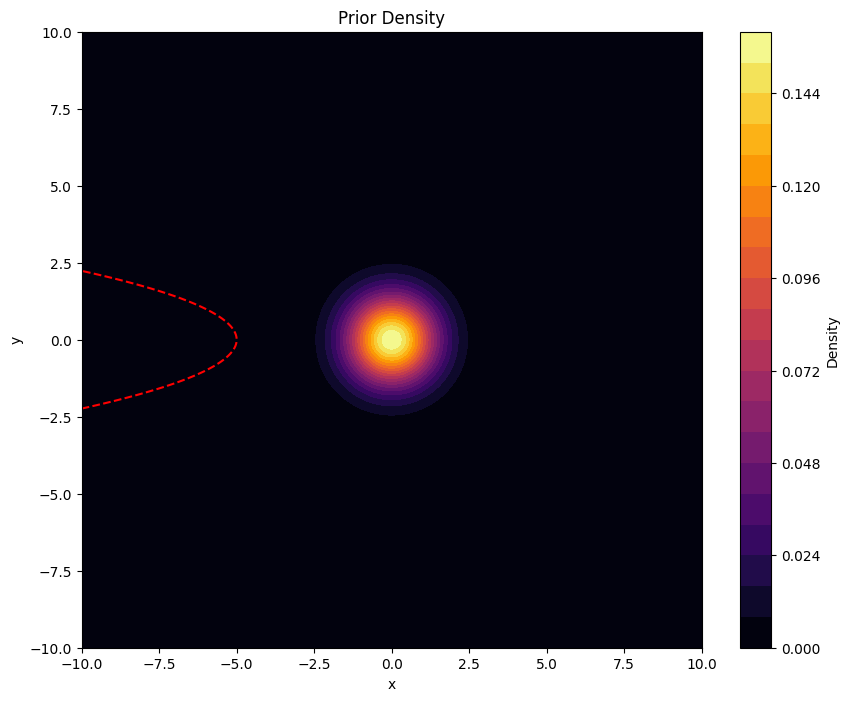

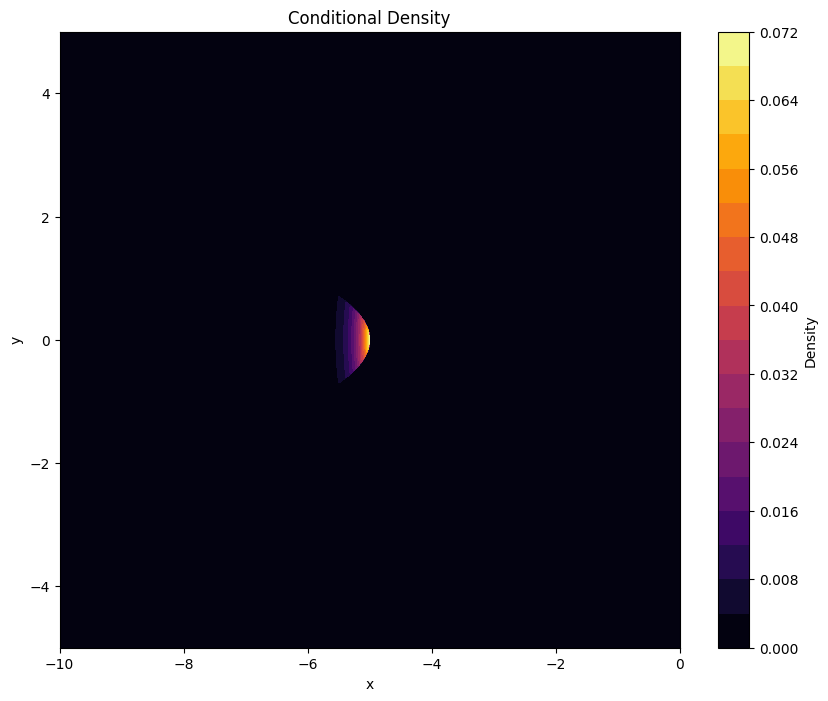

Integral of density: 0.998001
tensor(8.3565e-08)


In [1]:
# low-probability estimation using gaussians as the example distribution, and differentiable cost functions

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import tqdm

from scipy import integrate

from langevin import integrate_over_plane, SampleConfig, sample_langevin, animate_plots

cost_threshold = -5

def cost_function(xs):
    return xs[:, 1].pow(2) + xs[:, 0]

def prior_density(xs):
    return torch.exp(-xs.pow(2).sum(dim=-1) / 2) / (2 * np.pi) ** (xs.shape[-1] / 2)

def log_prior_density(xs):
    return -xs.pow(2).sum(dim=-1) / 2

img_size = 1000

full_lims = ((-10, 10), (-10, 10))
focus_lims = ((-10, 0), (-5, 5))

xs_full, ys_full = torch.meshgrid(torch.linspace(full_lims[0][0], full_lims[0][1], img_size), torch.linspace(full_lims[1][0], full_lims[0][1], img_size))
xs_focus, ys_focus = torch.meshgrid(torch.linspace(focus_lims[0][0], focus_lims[0][1], img_size), torch.linspace(focus_lims[1][0], focus_lims[1][1], img_size))

# plot density
points_full = torch.stack([xs_full, ys_full], dim=-1)

density_full = prior_density(points_full)

cost_full = cost_function(points_full.reshape(-1, 2)).reshape(points_full.shape[:-1])

plt.figure(figsize=(10, 8))
plt.contourf(xs_full.numpy(), ys_full.numpy(), density_full.numpy(), levels=20, cmap='inferno')
plt.colorbar(label='Density')
plt.contour(xs_full.numpy(), ys_full.numpy(), cost_full.numpy(), levels=[cost_threshold], colors='red')
plt.xlabel('x')
plt.ylabel('y') 
plt.title('Prior Density')
plt.show()

points_focus = torch.stack([xs_focus, ys_focus], dim=-1)
density_focus = prior_density(points_focus)
cost_focus = cost_function(points_focus.reshape(-1, 2)).reshape(points_focus.shape[:-1])

conditional_density_focus = density_focus.clone()
conditional_density_focus[cost_focus > cost_threshold] = 0
conditional_density_focus /= conditional_density_focus.sum() * (focus_lims[0][1] - focus_lims[0][0]) / img_size

plt.figure(figsize=(10, 8))
plt.contourf(xs_focus.numpy(), ys_focus.numpy(), conditional_density_focus.numpy(), levels=20, cmap='inferno')
plt.colorbar(label='Density')
plt.xlabel('x')
plt.ylabel('y') 
plt.title('Conditional Density')
plt.show()

# check that the prior density integrates to 1
integral = density_full.sum() * (full_lims[0][1] - full_lims[0][0]) * (full_lims[1][1] - full_lims[1][0]) / (img_size * img_size)
print(f"Integral of density: {integral.item():.6f}")

conditional_density_full = density_full.clone()
conditional_density_full[cost_full > cost_threshold] = 0
normalizing_constant = conditional_density_full.sum() * (full_lims[0][1] - full_lims[0][0]) * (full_lims[1][1] - full_lims[1][0]) / (img_size * img_size)

print(normalizing_constant)

In [2]:
def estimate_log_partition(samples, log_density, cost, n_temps=100, sample_config=SampleConfig(steps=1000)):
    num_samples, k = samples.shape

    def interpolated_density(xs, temp):
        return log_density(xs) - temp * sample_config.end_beta * torch.relu(cost(xs) - cost_threshold)

    log_weights = torch.zeros(num_samples, dtype=torch.float64)

    temps = [0] + list(np.logspace(-3, 0, n_temps))
    step_size = [0] + list(np.logspace(
        # np.log10(sample_config.start_lr),
        # np.log10(sample_config.end_lr),
        -2,
        -4,
        n_temps+1 # want to interpolate between start and end lr over n_temps steps
    ))

    # skip the first iteration because we already have the prior samples
    for i in tqdm.tqdm(range(1, n_temps+1)):
        iteration_sample_config = SampleConfig(
            # steps=sample_config.steps,
            # start_lr=step_size[i],
            # end_lr=step_size[i+1]
            steps=10_000,
            start_lr=0.001,
            end_lr=0.00001
        )
        
        samples = sample_langevin(
            particles=samples,
            log_density=lambda xs: interpolated_density(xs, temps[i]),
            config=iteration_sample_config,
            cost=None,
        )

        plt.hist2d(
            samples[:, 0].numpy(),
            samples[:, 1].numpy(),
            bins=100,
            cmap='inferno',
            density=True,
            range=full_lims,
            vmin=0,
            vmax=1,
        )
        plt.title(f"Step {i}")
        plt.colorbar()
        plt.savefig(f"bridge/xs_{i-1}.png")
        plt.close()

        log_weights += interpolated_density(samples, temps[i]) - interpolated_density(samples, temps[i-1])

    animate_plots("bridge", n_temps)

    log_Z = torch.logsumexp(log_weights, dim=0) - np.log(num_samples)
    return log_Z

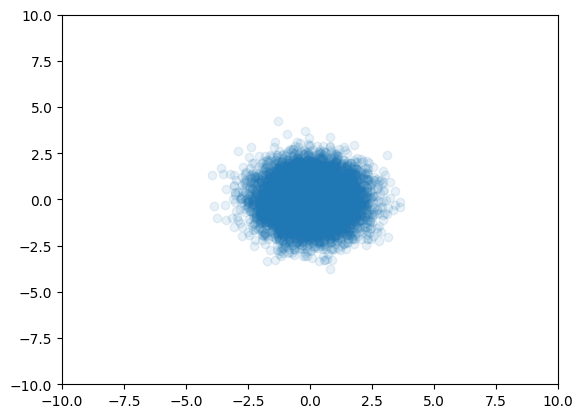

100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


Estimated normalizing constant: 1.32e-06
Actual normalizing constant: 8.36e-08


In [3]:
k = 2
log_Z_0 = (k / 2) * np.log(2 * np.pi)

samples = torch.randn((10_000, k), dtype=torch.float64)

plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), alpha=0.1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()
plt.close()

estimated_normalizing_constant = estimate_log_partition(samples, log_prior_density, cost_function) + log_Z_0

print(f"Estimated normalizing constant: {torch.exp(estimated_normalizing_constant).item():.2e}")
print(f"Actual normalizing constant: {normalizing_constant.item():.2e}")